# Discrete Convolution and Correlation

This notebook illustrates the (discrete) linear and circular convolutions.

* Graham, L., D. E. Knuth, and O. Patashnik (1994). Concrete mathematics: a foundation for computer science, 2 ed.: Addison-Wesley Publishing Company. ISBN 0-201-55802-5

* Yilmaz, Öz (2001). Seismic Data Analysis: Processing, Inversion, and Interpretation of Seismic Data, 2 ed.: Society of Exploration Geophysicists. ISBN 1-56080-098-4

* Oppenheim, A. V., and Schafer, R., W. (2010). Discrete-Time Signal Processing, 3 ed.: Pearson. ISBN 0-13-198842-5

In [1]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.linalg import toeplitz, circulant, dft
from scipy.signal import gaussian
import matplotlib.pyplot as plt
import my_functions as mfun
import fatiando_seismic as fseis

## Topics

* [Linear convolution 1D](#sec1)

* [Circular convolution 1D](#sec2)

* [Comparison between linear and circular convolutions 1D](sec3)

* [Crosscorrelation 1D](#sec4)

* [Autocorrelation 1D](#sec5)

<a id='sec1'></a>
## Linear convolution

Let $\mathbf{a}$ be an $N_{a} \times 1$ vector and $\mathbf{b}$ be an $N_{b} \times 1$ vector. The *linear convolution* of $\mathbf{a}$ and $\mathbf{b}$ generates a $N_{w} \times 1$ vector $\mathbf{w}$, where $N_{w} = N_{a} + N_{b} - 1$, whose $i$th element is defined as follows (Oppenheim and Shafer, 2010, p. 661):

<a id='eq1'></a>
$$
w_{i} = \sum\limits_{j = -\infty}^{\infty} b_{i - j} \, a_{j} \: . \tag{1}
$$

The linear convolution ([equation 1](#eq1)) is schematically represented as follows (e.g., Yilmaz, 2001, p. 39):

In [2]:
mfun.linear_convolution_scheme(Na=4, Nb=3)

Linear convolution:
w_0 = (b_0 * a_0) + (  0 * a_1) + (  0 * a_2) + (  0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_1 = (b_1 * a_0) + (b_0 * a_1) + (  0 * a_2) + (  0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_2 = (b_2 * a_0) + (b_1 * a_1) + (b_0 * a_2) + (  0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_3 = (  0 * a_0) + (b_2 * a_1) + (b_1 * a_2) + (b_0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_4 = (  0 * a_0) + (  0 * a_1) + (b_2 * a_2) + (b_1 * a_3) + (b_0 *   0) + (  0 *   0) + (  0 *   0)
w_5 = (  0 * a_0) + (  0 * a_1) + (  0 * a_2) + (b_2 * a_3) + (b_1 *   0) + (b_0 *   0) + (  0 *   0)
  0 = (  0 * a_0) + (  0 * a_1) + (  0 * a_2) + (  0 * a_3) + (b_2 *   0) + (b_1 *   0) + (b_0 *   0)


Toeplitz system:
|w_0|   |  b_0    0    0    0    0    0    0 |  |a_0|
|w_1|   |  b_1  b_0    0    0    0    0    0 |  |a_1|
|w_2|   |  b_2  b_1  b_0    0    0    0    0 |  |a_2|
|w_3| = |    0  b_2  b_1  b_0    0    0    0 |  |a_3|
|w_4|   |    0    0  b_2  b_1  

The scheme above shows that the linear convolution is a matrix-vector product:

<a id='eq2'></a>
$$
\begin{bmatrix}
\mathbf{w} \\
\hline
0
\end{bmatrix} = \mathbf{B} \, 
\begin{bmatrix}
\mathbf{a} \\
\hline
\mathbf{0}_{N_{b}}
\end{bmatrix} \quad , \tag{2}
$$

where $\mathbf{B}$ is a Toeplitz matrix. Matrix-vetor products with Toeplitz matrices have some special properties (see the notebook `Toeplitz-circulant-matrices.ipynb`) and can be computed by using the Fourier transform. Specifically, the linear convolution can be computed as follows:

<a id='eq3'></a>
$$
\begin{bmatrix}
\mathbf{w} \\
\hline
0
\end{bmatrix} 
= \mathbf{F}_{(N)}^{\ast} \Bigg\{ \left( \sqrt{N} \:\: \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{b} \\
\hline
\mathbf{0}_{N_{a}}
\end{bmatrix} \right) \circ 
\left( \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{a} \\
\hline
\mathbf{0}_{N_{b}}
\end{bmatrix} \right) \Bigg\} \: . \tag{3}
$$

Notice that [equation 3](#eq3) can be rewritten as follows:

<a id='eq4'></a>
$$
\mathbf{F}_{(N)}  
\begin{bmatrix}
\mathbf{w} \\
\hline
0
\end{bmatrix}
= \sqrt{N} \, 
\left( \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{b} \\
\hline
\mathbf{0}_{N_{a}}
\end{bmatrix} \right) \circ 
\left( \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{a} \\
\hline
\mathbf{0}_{N_{b}}
\end{bmatrix} \right) \: , \tag{4}
$$

which means that, despite the scaling factor $\sqrt{N}$, the DFT of the padded vector $\mathbf{w}$ is equal to the Hadamard product of the DFT's of the padded vectors $\mathbf{a}$ and $\mathbf{b}$.

The linear convolution of $\mathbf{a}$ and $\mathbf{b}$ is commonly found in the literature (e.g., Oppenheim and Schafer, 2010, p. 24) as follows:

<a id='eq5'></a>
$$
\mathbf{a} \ast \mathbf{b} \tag{5}
$$

As properly pointed out by (Oppenheim and Schafer, 2010, p. 24), the notation used in [equation 5](#eq5) "*is convenient and compact but needs to be used with caution*". The important thing here is knowing how to relate [equation 5](#eq5) and equations [2](#eq2) and [4](#eq4):

* In the **data domain**, [equation 5](#eq5) is equivalent to [equation 2](#eq2), which is a linear convolution and produces the data vector $\begin{bmatrix} \mathbf{w} \\ \hline 0 \end{bmatrix}$ by computing the product of the Toeplitz matrix $\mathbf{B}$ and the padded vector $\begin{bmatrix} \mathbf{a} \\ \hline \mathbf{0}_{N_{b}} \end{bmatrix}$.

* In the **Fourier domain**, [equation 5](#eq5) is equivalent to [equation 4](#eq4), which is a linear convolution and produces the DFT of data vector $\begin{bmatrix} \mathbf{w} \\ \hline 0 \end{bmatrix}$ by computing the Hadamard product of the DFT of the padded vector $\begin{bmatrix} \mathbf{b} \\ \hline \mathbf{0}_{N_{a}} \end{bmatrix}$ and the padded vector $\begin{bmatrix} \mathbf{a} \\ \hline \mathbf{0}_{N_{b}} \end{bmatrix}$.

In [3]:
# number of data points in a
Na = 300

# data vector a
a = np.zeros(Na)
a[100] = 1.
a[200] = -2.

# number of data points in b
Nb = 30

# data vector b
b = gaussian(Nb, 3, sym=True)

In [4]:
# number of elements in w
Nw = Na + Nb - 1

In [5]:
N = Na+Nb

In [6]:
# vector a padded with zeros
a_padd = np.hstack([a, np.zeros(Nb)])

In [7]:
# vector b padded with zeros
b_padd = np.hstack([b, np.zeros(Na)])

In [8]:
# Toeplitz matrix B
B = toeplitz(b_padd, np.zeros(N))

In [9]:
# linear convolution computed as a matrix-vector product
w_lin_conv_matvec_Ba = np.dot(B, a_padd)[:-1]

In [10]:
# linear convolution computed by FFT
DFT_a_padd = fft(x=a_padd, norm='ortho')
DFT_b_padd = fft(x=b_padd, norm='ortho')
w_lin_conv_fft_ab = ifft(x=np.sqrt(N)*DFT_a_padd*DFT_b_padd, norm='ortho').real[:-1]

In [11]:
np.allclose(w_lin_conv_matvec_Ba, w_lin_conv_fft_ab)

True

In [12]:
# linear convolution computed by using numpy.convolve
w_convolve_ab = np.convolve(a, b, mode='full')

In [13]:
np.allclose(w_lin_conv_matvec_Ba, w_convolve_ab)

True

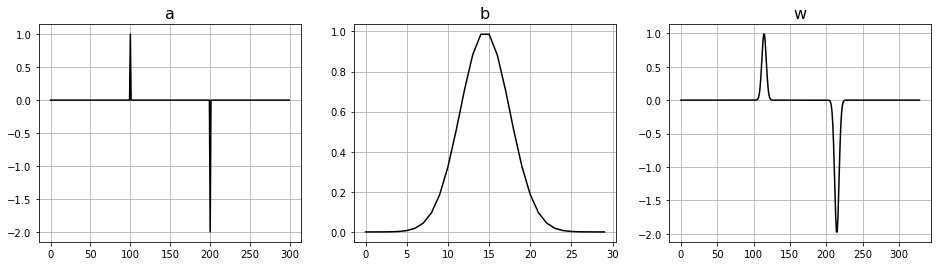

In [14]:
plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.title('a', fontsize=16)
plt.plot(a, 'k-')
plt.grid()

plt.subplot(1,3,2)
plt.title('b', fontsize=16)
plt.plot(b, 'k-')
plt.grid()

plt.subplot(1,3,3)
plt.title('w', fontsize=16)
plt.plot(w_lin_conv_matvec_Ba, 'k-')
plt.grid()

plt.show()

We have just computed the linear convolution of $\mathbf{a}$ and $\mathbf{b}$. What about the linear convolution of $\mathbf{b}$ and $\mathbf{a}$?

In [15]:
# Toeplitz matrix A
A = toeplitz(a_padd, np.zeros(N))

# linear convolution computed as a matrix-vector product
w_lin_conv_matvec_Ab = np.dot(A, b_padd)[:-1]

In [16]:
# linear convolution computed by FFT
DFT_a_padd = fft(x=a_padd, norm='ortho')
DFT_b_padd = fft(x=b_padd, norm='ortho')
w_lin_conv_fft_ba = ifft(x=np.sqrt(N)*DFT_b_padd*DFT_a_padd, norm='ortho').real[:-1]

In [17]:
# linear convolution computed by using numpy.convolve
w_convolve_ba = np.convolve(b, a, mode='full')

In [18]:
np.allclose(w_lin_conv_fft_ba, w_lin_conv_matvec_Ab)

True

In [19]:
np.allclose(w_convolve_ba, w_lin_conv_matvec_Ab)

True

In [20]:
np.allclose(w_lin_conv_fft_ba, w_lin_conv_fft_ab)

True

In [21]:
np.allclose(w_lin_conv_matvec_Ba, w_lin_conv_matvec_Ab)

True

<a id='sec2'></a>
## Circular convolution

Let $\mathbf{a}$ and $\mathbf{b}$ be $N \times 1$ vectors. The circular convolution of $\mathbf{a}$ and $\mathbf{b}$ generates an $N \times 1$ vector $\mathbf{w}$ whose $i$th element is defined as follows:

<a id='eq6'></a>
$$
w_{i} = \sum\limits_{j = 0}^{N-1} b_{(i - j)\text{mod}N} \, a_{j} \: . \tag{6}
$$

The **mod** function $x \, \text{mod} \, y$ (Graham et al., 1994, p. 82) computes the remainder of division of `x` by `y`. It can be rewritten as follows:

<a id='eq7'></a>
$$
x \, \text{mod} \, y = x - y \, \Big\lfloor \frac{x}{y} \Big\rfloor \: , \tag{7}
$$

where $\lfloor \cdot \rfloor$ denotes the **floor** function (Graham et al., 1994, p. 67), which computes the
greatest integer less than or equal to its argument. The mod function is implemented in the routine [`numpy.mod`](https://numpy.org/doc/stable/reference/generated/numpy.mod.html).

In [22]:
mfun.circular_convolution_scheme(N=4)

Circular convolution:
w_0 = (b_0 * a_0) + (b_3 * a_1) + (b_2 * a_2) + (b_1 * a_3)
w_1 = (b_1 * a_0) + (b_0 * a_1) + (b_3 * a_2) + (b_2 * a_3)
w_2 = (b_2 * a_0) + (b_1 * a_1) + (b_0 * a_2) + (b_3 * a_3)
w_3 = (b_3 * a_0) + (b_2 * a_1) + (b_1 * a_2) + (b_0 * a_3)


Circulant system:
|w_0|   |  b_0  b_3  b_2  b_1 |  |a_0|
|w_1|   |  b_1  b_0  b_3  b_2 |  |a_1|
|w_2| = |  b_2  b_1  b_0  b_3 |  |a_2|
|w_3|   |  b_3  b_2  b_1  b_0 |  |a_3|


The scheme above shows that the circular convolution is a matrix-vector product:

<a id='eq8'></a>
$$
\mathbf{w} = \mathbf{C} \, \mathbf{a} \quad , \tag{8}
$$

where $\mathbf{C}$ is a circulant matrix. Matrix-vetor products with circulant matrices have some special properties (see the notebook `Toeplitz-circulant-matrices.ipynb`) and can be computed by using the Fourier transform. Specifically, the circular convolution can be computed as follows:

<a id='eq9'></a>
$$
\mathbf{w} = \mathbf{F}_{(N)}^{\ast} \Bigg\{ \left( \sqrt{N} \:\: 
\mathbf{F}_{(N)} \, \mathbf{b} \right) \circ 
\left( \mathbf{F}_{(N)} \, \mathbf{a} \right) \Bigg\} \quad . \tag{9}
$$

Notice that [equation 9](#eq9) can be rewritten as follows:

<a id='eq10'></a>
$$
\mathbf{F}_{(N)} \mathbf{w} = \sqrt{N} \, \left( \mathbf{F}_{(N)} \, \mathbf{b} \right) \circ 
\left( \mathbf{F}_{(N)} \, \mathbf{a} \right) \quad , \tag{10}
$$

which means that, despite the scaling factor $\sqrt{N}$, the DFT of the vector $\mathbf{w}$ is equal to the Hadamard product of the DFT's of the vectors $\mathbf{a}$ and $\mathbf{b}$.

The circular convolution of $\mathbf{a}$ and $\mathbf{b}$ is also commonly found in the literature (e.g., Oppenheim and Schafer, 2010, p. 24) in the form of [equation 5](#eq5).

Again, the important thing here is knowing how to relate [equation 5](#eq5) and equations [8](#eq8) and [10](#eq10):

* In the **data domain**, [equation 5](#eq5) is equivalent to [equation 8](#eq8), which is a circular convolution and produces the data vector $\mathbf{w}$ by computing the product of the circulant matrix $\mathbf{C}$ and the vector $\mathbf{a}$, without padding anything.

* In the **Fourier domain**, [equation 5](#eq5) is equivalent to [equation 10](#eq10), which is a circular convolution and produces the DFT of data vector $\mathbf{w}$ by computing the Hadamard product of the DFT of the vector $\mathbf{b}$ and the vector $\mathbf{a}$, without padding anything.

In [23]:
# number of data points
N = 100

# data vector a
a = 10*np.random.rand(N)

# data vector b
b = 10*np.random.rand(N)

In [24]:
# Circulant matrix C
C = circulant(b)

In [25]:
# circular convolution computed as a matrix-vector product
w_circ_conv_matvec_Ca = np.dot(C, a)

In [26]:
# circular convolution computed by FFT
DFT_a = fft(x=a, norm='ortho')
DFT_b = fft(x=b, norm='ortho')
w_circ_conv_fft_ab = ifft(x=np.sqrt(N)*DFT_a*DFT_b, norm='ortho').real

In [27]:
np.allclose(w_circ_conv_matvec_Ca, w_circ_conv_fft_ab)

True

<a id='sec3'></a>
## Comparison between linear and circular convolutions

In [28]:
mfun.linear_convolution_scheme(Na=3, Nb=3)

Linear convolution:
w_0 = (b_0 * a_0) + (  0 * a_1) + (  0 * a_2) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_1 = (b_1 * a_0) + (b_0 * a_1) + (  0 * a_2) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_2 = (b_2 * a_0) + (b_1 * a_1) + (b_0 * a_2) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_3 = (  0 * a_0) + (b_2 * a_1) + (b_1 * a_2) + (b_0 *   0) + (  0 *   0) + (  0 *   0)
w_4 = (  0 * a_0) + (  0 * a_1) + (b_2 * a_2) + (b_1 *   0) + (b_0 *   0) + (  0 *   0)
  0 = (  0 * a_0) + (  0 * a_1) + (  0 * a_2) + (b_2 *   0) + (b_1 *   0) + (b_0 *   0)


Toeplitz system:
|w_0|   |  b_0    0    0    0    0    0 |  |a_0|
|w_1|   |  b_1  b_0    0    0    0    0 |  |a_1|
|w_2|   |  b_2  b_1  b_0    0    0    0 |  |a_2|
|w_3| = |    0  b_2  b_1  b_0    0    0 |  |  0|
|w_4|   |    0    0  b_2  b_1  b_0    0 |  |  0|
|  0|   |    0    0    0  b_2  b_1  b_0 |  |  0|


In [29]:
mfun.circular_convolution_scheme(N=3)

Circular convolution:
w_0 = (b_0 * a_0) + (b_2 * a_1) + (b_1 * a_2)
w_1 = (b_1 * a_0) + (b_0 * a_1) + (b_2 * a_2)
w_2 = (b_2 * a_0) + (b_1 * a_1) + (b_0 * a_2)


Circulant system:
|w_0|   |  b_0  b_2  b_1 |  |a_0|
|w_1| = |  b_1  b_0  b_2 |  |a_1|
|w_2|   |  b_2  b_1  b_0 |  |a_2|


In [30]:
mfun.circular_convolution_scheme(N=6)

Circular convolution:
w_0 = (b_0 * a_0) + (b_5 * a_1) + (b_4 * a_2) + (b_3 * a_3) + (b_2 * a_4) + (b_1 * a_5)
w_1 = (b_1 * a_0) + (b_0 * a_1) + (b_5 * a_2) + (b_4 * a_3) + (b_3 * a_4) + (b_2 * a_5)
w_2 = (b_2 * a_0) + (b_1 * a_1) + (b_0 * a_2) + (b_5 * a_3) + (b_4 * a_4) + (b_3 * a_5)
w_3 = (b_3 * a_0) + (b_2 * a_1) + (b_1 * a_2) + (b_0 * a_3) + (b_5 * a_4) + (b_4 * a_5)
w_4 = (b_4 * a_0) + (b_3 * a_1) + (b_2 * a_2) + (b_1 * a_3) + (b_0 * a_4) + (b_5 * a_5)
w_5 = (b_5 * a_0) + (b_4 * a_1) + (b_3 * a_2) + (b_2 * a_3) + (b_1 * a_4) + (b_0 * a_5)


Circulant system:
|w_0|   |  b_0  b_5  b_4  b_3  b_2  b_1 |  |a_0|
|w_1|   |  b_1  b_0  b_5  b_4  b_3  b_2 |  |a_1|
|w_2|   |  b_2  b_1  b_0  b_5  b_4  b_3 |  |a_2|
|w_3| = |  b_3  b_2  b_1  b_0  b_5  b_4 |  |a_3|
|w_4|   |  b_4  b_3  b_2  b_1  b_0  b_5 |  |a_4|
|w_5|   |  b_5  b_4  b_3  b_2  b_1  b_0 |  |a_5|


Circular convolution generates the same result as linear convolution if the input vectors are padded with zeros.

<a id='sec4'></a>
## Crosscorrelation

Let $\mathbf{a}$ be an $N_{a} \times 1$ vector and $\mathbf{b}$ be an $N_{b} \times 1$ vector. The *crosscorrelation* of $\mathbf{a}$ and $\mathbf{b}$ generates a $N \times 1$ vector $\mathbf{w}$, where $N = N_{a} + N_{b} - 1$, whose $i$th element is defined as follows:

<a id='eq11'></a>
$$
w_{i} = \sum\limits_{j = 0}^{N-1} b_{i + j} \, a_{j} \: . \tag{11}
$$

The crosscorrelation is schematically represented as follows (e.g., Yilmaz, 2001, p. 40):

In [31]:
mfun.crosscorrelation_scheme(Na=4, Nb=3)

Crosscorrelation:
w_-2 = (b_2 * a_0) + (  0 * a_1) + (  0 * a_2) + (  0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_-1 = (b_1 * a_0) + (b_2 * a_1) + (  0 * a_2) + (  0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
 w_0 = (b_0 * a_0) + (b_1 * a_1) + (b_2 * a_2) + (  0 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
 w_1 = (  0 * a_0) + (b_0 * a_1) + (b_1 * a_2) + (b_2 * a_3) + (  0 *   0) + (  0 *   0) + (  0 *   0)
 w_2 = (  0 * a_0) + (  0 * a_1) + (b_0 * a_2) + (b_1 * a_3) + (b_2 *   0) + (  0 *   0) + (  0 *   0)
 w_3 = (  0 * a_0) + (  0 * a_1) + (  0 * a_2) + (b_0 * a_3) + (b_1 *   0) + (b_2 *   0) + (  0 *   0)
   0 = (  0 * a_0) + (  0 * a_1) + (  0 * a_2) + (  0 * a_3) + (b_0 *   0) + (b_1 *   0) + (b_2 *   0)


Toeplitz system:
|w_-2|   |  b_2    0    0    0    0    0    0 |  |a_0|
|w_-1|   |  b_1  b_2    0    0    0    0    0 |  |a_1|
| w_0|   |  b_0  b_1  b_2    0    0    0    0 |  |a_2|
| w_1| = |    0  b_0  b_1  b_2    0    0    0 |  |a_3|
| w_2|   |    0    0  

The scheme above shows that the linear convolution is a matrix-vector product:

<a id='eq12'></a>
$$
\begin{bmatrix}
\mathbf{w} \\
\hline
0
\end{bmatrix} = \tilde{\mathbf{B}} \, 
\begin{bmatrix}
\mathbf{a} \\
\hline
\mathbf{0}_{N_{b}}
\end{bmatrix} \quad , \tag{12}
$$

where $\tilde{\mathbf{B}}$ is a Toeplitz matrix.

What is the difference between the Toeplitz matrices of crosscorrelation ([equation 12](#eq12)) and linear convolution ([equation 2](#eq2))?

Matrix-vetor products with Toeplitz matrices have some special properties (see the notebook `Toeplitz-circulant-matrix-vector.ipynb`) and can be computed by using the Fourier transform. Specifically, the linear convolution can be computed as follows:

<a id='eq13'></a>
$$
\begin{bmatrix}
\mathbf{w} \\
\hline
0
\end{bmatrix} 
= \mathbf{F}_{(N)}^{\ast} \Bigg\{ \left( \sqrt{N} \:\: \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{b}[::-1] \\
\hline
\mathbf{0}_{N_{a}}
\end{bmatrix} \right) \circ 
\left( \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{a} \\
\hline
\mathbf{0}_{N_{b}}
\end{bmatrix} \right) \Bigg\} \: . \tag{13}
$$

Notice that [equation 13](#eq13) can be rewritten as follows:

<a id='eq14'></a>
$$
\mathbf{F}_{(N)}  
\begin{bmatrix}
\mathbf{w} \\
\hline
0
\end{bmatrix}
= \sqrt{N} \, 
\left( \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{b}[::-1] \\
\hline
\mathbf{0}_{N_{a}}
\end{bmatrix} \right) \circ 
\left( \mathbf{F}_{(N)} 
\begin{bmatrix}
\mathbf{a} \\
\hline
\mathbf{0}_{N_{b}}
\end{bmatrix} \right) \: , \tag{14}
$$

which means that, despite the scaling factor $\sqrt{N}$, the DFT of the padded vector $\mathbf{w}$ is equal to the Hadamard product of the DFT's of the padded vectors $\mathbf{a}$ and $\mathbf{b}[::-1]$.

In [32]:
# number of data points in a
Na = 40

# data vector a
a = np.concatenate([np.zeros(Na-15), gaussian(15, 2)])

# number of data points in b
Nb = 30

# data vector b
b = np.concatenate([gaussian(13, 2), np.zeros(Nb-13)])

In [33]:
# number of elements in w
Nw = Na + Nb - 1

In [34]:
N = Na + Nb

In [35]:
# vector a padded with zeros
a_padd = np.hstack([a, np.zeros(Nb)])

In [36]:
# inversed vector b padded with zeros
b_padd = np.hstack([b[::-1], np.zeros(Na)])

In [37]:
# Toeplitz matrix B formed with inversed b
B = toeplitz(b_padd, np.zeros(N))

In [38]:
# crosscorrelation computed as a matrix-vector product
w_cross_matvec_Ba = np.dot(B, a_padd)[:-1]

In [39]:
# crosscorrelation computed by FFT
DFT_a_padd = fft(x=a_padd, norm='ortho')
DFT_b_padd = fft(x=b_padd, norm='ortho')
w_cross_fft_ab = ifft(x=np.sqrt(N)*DFT_a_padd*DFT_b_padd, norm='ortho').real[:-1]

In [40]:
np.allclose(w_cross_matvec_Ba, w_cross_fft_ab)

True

In [41]:
# crosscorrelation computed by using numpy.correlate
w_correlate_ab = np.correlate(a, b, mode='full')

In [42]:
np.allclose(w_cross_fft_ab, w_correlate_ab)

True

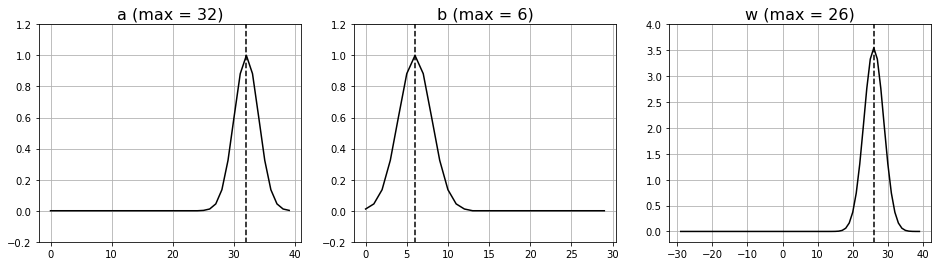

In [43]:
plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.title('a (max = {:d})'.format(np.argmax(a)), fontsize=16)
plt.plot(a, 'k-')
plt.plot([np.argmax(a), np.argmax(a)], [-1, 2], 'k--')
plt.ylim(-0.2, 1.2)
plt.grid()

plt.subplot(1,3,2)
plt.title('b (max = {:d})'.format(np.argmax(b)), fontsize=16)
plt.plot(b, 'k-')
plt.plot([np.argmax(b), np.argmax(b)], [-1, 2], 'k--')
plt.ylim(-0.2, 1.2)
plt.grid()

plt.subplot(1,3,3)
plt.title('w (max = {:d})'.format(np.argmax(w_cross_matvec_Ba)-Nb+1), fontsize=16)
plt.plot(np.arange(-Nb+1, Na), w_cross_matvec_Ba, 'k-')
plt.plot([np.argmax(w_cross_matvec_Ba)-Nb+1, np.argmax(w_cross_matvec_Ba)-Nb+1], [-1, 5], 'k--')
plt.ylim(-0.2, 4)
plt.grid()

plt.show()

In [44]:
32-6

26

We have just computed the crosscorrelation of $\mathbf{a}$ and $\mathbf{b}$. What about the crosscorrelation of $\mathbf{b}$ and $\mathbf{a}$?

In [45]:
# inversed vector a padded with zeros
a_padd = np.hstack([a[::-1], np.zeros(Nb)])

In [46]:
# vector b padded with zeros
b_padd = np.hstack([b, np.zeros(Na)])

In [47]:
# Toeplitz matrix A
A = toeplitz(a_padd, np.zeros(N))

# crosscorrelation computed as a matrix-vector product
w_cross_matvec_Ab = np.dot(A, b_padd)[:-1]

In [48]:
# crosscorrelation computed by FFT
DFT_a_padd = fft(x=a_padd, norm='ortho')
DFT_b_padd = fft(x=b_padd, norm='ortho')
w_cross_fft_ba = ifft(x=np.sqrt(N)*DFT_b_padd*DFT_a_padd, norm='ortho').real[:-1]

In [49]:
# crosscorrelation computed by using numpy.correlate
w_correlate_ba = np.correlate(b, a, mode='full')

In [50]:
np.allclose(w_cross_fft_ba, w_cross_matvec_Ab)

True

In [51]:
np.allclose(w_correlate_ba, w_cross_matvec_Ab)

True

In [52]:
np.allclose(w_cross_fft_ba, w_cross_fft_ab)

False

In [53]:
np.allclose(w_cross_matvec_Ba, w_cross_matvec_Ab)

False

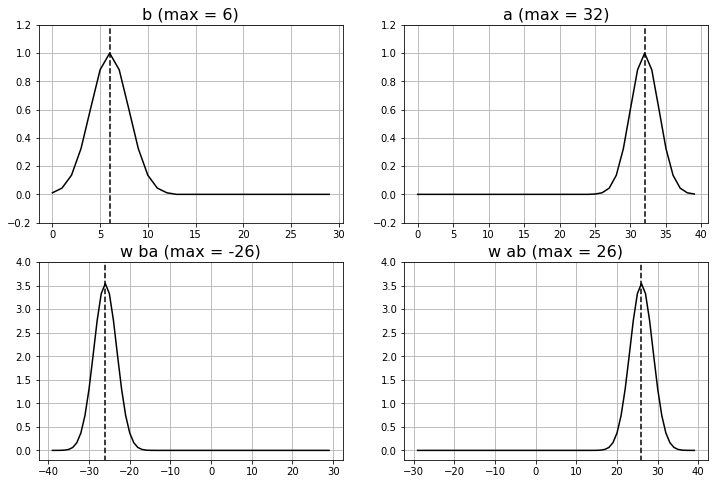

In [54]:
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.title('b (max = {:d})'.format(np.argmax(b)), fontsize=16)
plt.plot(b, 'k-')
plt.plot([np.argmax(b), np.argmax(b)], [-1, 2], 'k--')
plt.ylim(-0.2, 1.2)
plt.grid()

plt.subplot(2,2,2)
plt.title('a (max = {:d})'.format(np.argmax(a)), fontsize=16)
plt.plot(a, 'k-')
plt.plot([np.argmax(a), np.argmax(a)], [-1, 2], 'k--')
plt.ylim(-0.2, 1.2)
plt.grid()

plt.subplot(2,2,3)
plt.title('w ba (max = {:d})'.format(np.argmax(w_cross_matvec_Ab)-Na+1), fontsize=16)
plt.plot(np.arange(-Na+1, Nb), w_cross_matvec_Ab, 'k-')
plt.plot([np.argmax(w_cross_matvec_Ab)-Na+1, np.argmax(w_cross_matvec_Ab)-Na+1], [-1, 5], 'k--')
plt.ylim(-0.2, 4)
plt.grid()

plt.subplot(2,2,4)
plt.title('w ab (max = {:d})'.format(np.argmax(w_cross_matvec_Ba)-Nb+1), fontsize=16)
plt.plot(np.arange(-Nb+1, Na), w_cross_matvec_Ba, 'k-')
plt.plot([np.argmax(w_cross_matvec_Ba)-Nb+1, np.argmax(w_cross_matvec_Ba)-Nb+1], [-1, 5], 'k--')
plt.ylim(-0.2, 4)
plt.grid()

plt.show()

<a id='sec5'></a>
## Autocorrelation

If vectors $\mathbf{a}$ and $\mathbf{b}$ are the same, the crosscorrelation is called *autocorrelation*.

In [55]:
mfun.autocorrelation_scheme(N=3)

Autocorrelation:
w_-2 = (a_2 * a_0) + (  0 * a_1) + (  0 * a_2) + (  0 *   0) + (  0 *   0) + (  0 *   0)
w_-1 = (a_1 * a_0) + (a_2 * a_1) + (  0 * a_2) + (  0 *   0) + (  0 *   0) + (  0 *   0)
 w_0 = (a_0 * a_0) + (a_1 * a_1) + (a_2 * a_2) + (  0 *   0) + (  0 *   0) + (  0 *   0)
 w_1 = (  0 * a_0) + (a_0 * a_1) + (a_1 * a_2) + (a_2 *   0) + (  0 *   0) + (  0 *   0)
 w_2 = (  0 * a_0) + (  0 * a_1) + (a_0 * a_2) + (a_1 *   0) + (a_2 *   0) + (  0 *   0)
   0 = (  0 * a_0) + (  0 * a_1) + (  0 * a_2) + (a_0 *   0) + (a_1 *   0) + (a_2 *   0)


Toeplitz system:
|w_-2|   |  a_2    0    0    0    0    0 |  |a_0|
|w_-1|   |  a_1  a_2    0    0    0    0 |  |a_1|
| w_0|   |  a_0  a_1  a_2    0    0    0 |  |a_2|
| w_1| = |    0  a_0  a_1  a_2    0    0 |  |  0|
| w_2|   |    0    0  a_0  a_1  a_2    0 |  |  0|
|   0|   |    0    0    0  a_0  a_1  a_2 |  |  0|


In [56]:
# number of data points in a
N = 100

# data vector a
a = np.random.rand(N)

In [57]:
w_correlate = np.correlate(a, a, mode='full')

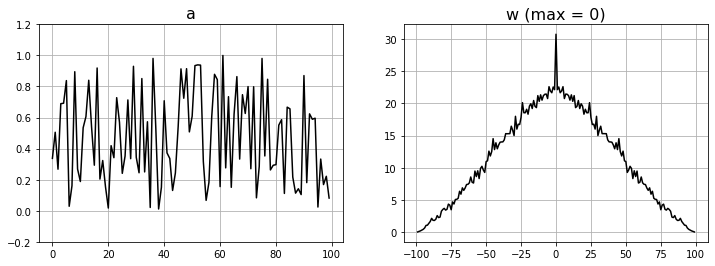

In [58]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.title('a', fontsize=16)
plt.plot(a, 'k-')
plt.ylim(-0.2, 1.2)
plt.grid()

plt.subplot(1,2,2)
plt.title('w (max = {:d})'.format(np.argmax(w_correlate)-N+1), fontsize=16)
plt.plot(np.arange(-N+1, N), w_correlate, 'k-')
#plt.ylim(-0.2, 4)
plt.grid()

plt.show()